In [ ]:
import numpy as np
from codes.plotting import plot_prettier, plot_histogram
plot_prettier()
zgc = np.loadtxt('https://astro.uchicago.edu/~andrey/classes/a211/data/gcz.dat', usecols=(1), unpack=True)

nbins = # enter the number of bins here
plot_histogram(zgc, xlabel='[Fe/H]', ylabel='N', tickmarks=True, bins=nbins)

SyntaxError: invalid syntax (<ipython-input-1-72a64f3cb635>, line 6)

In [ ]:
import numpy as np
import pandas as pd
import math
from matplotlib import pylab as plt
from matplotlib.colors import LogNorm
from IPython.display import display
from IPython.display import clear_output
from IPython.core.display import display, HTML
from google.colab import files
from scipy import stats
from scipy.signal import argrelextrema
import time
from numpy.ma import count
from typing import Counter
import ipywidgets as widgets
import tabulate

In [ ]:
class DataSet:
  def __init__(self):
    uploaded = files.upload()
    df_name = next(iter(uploaded.keys()))
    table = pd.read_table(df_name, delimiter=",", header=0)
    self.t, self.snoutx, self.snouty, self.gillx, self.gilly = table["Time"], table["Snout X"], table["Snout Y"], table["COM X"], table["COM Y"]
    self.lpfx, self.lpfy, self.rpfx, self.rpfy = table["Left Pec X"], table["Left Pec Y"], table["Right Pec X"], table["Right Pec Y"]
    self.afx, self.afy, self.vtx, self.vty = table["Anal Fin X"], table["Anal Fin Y"], table["Tail X"], table["Tail Y"]
    self.listofvars = [self.snoutx, self.snouty, self.gillx, self.gilly, self.lpfx, self.lpfy, self.rpfx, self.rpfy, self.afx, self.afy, self.vtx, self.vty]

  def shift_axes(self): # Relates all coordinates to fish's snout and center of mass
    # to rid of data points where a variable is (0,0)
    breaker = 0
    goodones = np.ones(len(self.snoutx))
    for i, vol in enumerate(self.snoutx):
      breaker = 0
      for j, val in enumerate(self.listofvars):
        if val[i] == 0 and j%2 == 0:
          if self.listofvars[j+1][i] == 0:
            breaker = 1
      if breaker ==1:
        goodones[i] = 0

  #Create spreadsheet with snout at the origin
    master = np.zeros((len(self.t), len(self.listofvars)+1))
    for i, val in enumerate(self.t):
      if goodones[i] == 1:
        master[i] = self.t[i], 0, 0, self.gillx[i]-self.snoutx[i], self.gilly[i]-self.snouty[i], self.lpfx[i]-self.snoutx[i],
        self.lpfy[i]-self.snouty[i], self.rpfx[i]-self.snoutx[i], self.rpfy[i]-self.snouty[i],
        self.afx[i]-self.snoutx[i], self.afy[i]-self.snouty[i], self.vtx[i]-self.snoutx[i], self.vty[i]-self.snouty[i]
    breaker = 0
    ticker = 0
    while breaker ==0:
      if master[ticker][0] == 0:
        master = np.delete(master, ticker, 0)
      else:
        ticker += 1
      if ticker+1 > np.size(master, 0):
        breaker = 1
  #shift pec fins, anal fin, ventral tail with respect to their angle relative to snout:gill junction
    self.nrows, self.ncols = master.shape
    for i in range(self.nrows):
      #left pec fin
      p1 = [master[i][3], master[i][4]]
      p2 = [master[i][1], master[i][2]]
      p3 = [master[i][5], master[i][6]]
      p21 = np.array(p1) - np.array(p2)
      p23 = np.array(p3) - np.array(p2)
      cosine_angle = np.dot(p21, p23) / (np.linalg.norm(p21) * np.linalg.norm(p23))
      angle = np.arccos(cosine_angle)
      if ((p3[1]-p2[1])/(p3[0]-p2[0])) < ((p1[1]-p2[1])/(p1[0]-p2[0])):
        angle = -1 * angle
      distan = math.dist(p2, p3)
      master[i][5] = distan * np.cos(angle)
      master[i][6] = distan * np.sin(angle)

      #right pec fin
      p1 = [master[i][3], master[i][4]]
      p2 = [master[i][1], master[i][2]]
      p3 = [master[i][7], master[i][8]]
      p21 = np.array(p1) - np.array(p2)
      p23 = np.array(p3) - np.array(p2)
      cosine_angle = np.dot(p21, p23) / (np.linalg.norm(p21) * np.linalg.norm(p23))
      angle = np.arccos(cosine_angle)
      if ((p3[1]-p2[1])/(p3[0]-p2[0])) < ((p1[1]-p2[1])/(p1[0]-p2[0])):
        angle = -1 * angle
      distan = math.dist(p2, p3)
      master[i][7] = distan * np.cos(angle)
      master[i][8] = distan * np.sin(angle)

      #anal fin
      p1 = [master[i][3], master[i][4]]
      p2 = [master[i][1], master[i][2]]
      p3 = [master[i][9], master[i][10]]
      p21 = np.array(p1) - np.array(p2)
      p23 = np.array(p3) - np.array(p2)
      cosine_angle = np.dot(p21, p23) / (np.linalg.norm(p21) * np.linalg.norm(p23))
      angle = np.arccos(cosine_angle)
      if ((p3[1]-p2[1])/(p3[0]-p2[0])) < ((p1[1]-p2[1])/(p1[0]-p2[0])):
        angle = -1 * angle
      distan = math.dist(p2, p3)
      master[i][9] = distan * np.cos(angle)
      master[i][10] = distan * np.sin(angle)

      #ventral tail
      p1 = [master[i][3], master[i][4]]
      p2 = [master[i][1], master[i][2]]
      p3 = [master[i][11], master[i][12]]
      p21 = np.array(p1) - np.array(p2)
      p23 = np.array(p3) - np.array(p2)
      cosine_angle = np.dot(p21, p23) / (np.linalg.norm(p21) * np.linalg.norm(p23))
      angle = np.arccos(cosine_angle)
      if ((p3[1]-p2[1])/(p3[0]-p2[0])) < ((p1[1]-p2[1])/(p1[0]-p2[0])):
        angle = -1 * angle
      distan = math.dist(p2, p3)
      master[i][11] = distan * np.cos(angle)
      master[i][12] = distan * np.sin(angle)

  #Adjust gill junction to also be on the x-axis
    for i in range(self.nrows):
      p1 = [master[i][1], master[i][2]]
      p2 = [master[i][3], master[i][4]]
      master[i][3] = math.dist(p1, p2)
      master[i][4] = 0
    self.master = master

  def gross_trends(self):
    print(self.snoutx)
    x = self.snoutx[-1] - self.snoutx[0]
    y = self.snouty[-1] - self.snouty[0]
    intanrad = math.atan(y/x)
    ang = math.degrees(intanrad)
    time = 0.1333333333* (self.t[-1]-self.t[0])
    displacement = math.sqrt((y)^2 + (x)^2)
    speed = displacement / time

    data = [ang, x, y, speed]
    header = ["ang moved", "x", "y", "speed"]
    table = tabulate(data, headers=header, tablefmt="grid")
    print(table)

  def rhythmicity(self):
    rareas = []
    lareas = []
    for i in range(self.nrows):
      #Establishing points along triangle representing pushed water
      baser = abs(self.master[i][7] - self.master[i][3])
      heightr = self.master[i][8]
      rxcor= [self.master[i][3], baser, baser, self.master[i][3]]
      rycor= [0, 0, heightr, 0]
      basel = abs(self.master[i][5] - self.master[i][3])
      heightl = self.master[i][6]
      lxcor= [self.master[i][3], basel, basel, self.master[i][3]]
      lycor= [0, 0, heightl, 0]
      #For actual calculations
      rareas.append(baser * heightr * 0.5)
      lareas.append(basel * heightl * 0.5)
    tareas = []
    for h in range(self.nrows):
      area = 0
      x = [self.master[h][3], self.master[h][11], self.master[h][11], self.master[h][9]]
      y = [0, 0, self.master[h][12], self.master[h][10]]
      # For calculating area
      for i in range(4):
        j = (i + 1) % 4
        area += x[i] * y[j]
        area -= x[j] * y[i]
      area = area/2
      tareas.append(area)

    names = ["Right Pec", "Left Pec", "Tail"]
    namevs = [rareas, lareas, tareas]
    vals = np.empty(3)
    for y, x in enumerate(names):
      j = 0
      lines = []
      while j == 0:
        x_values = self.master[:,0]
        y_values = namevs[y]
        print(len(self.master[:,0]))
        print(len(y_values))
        line_values = [2.5]  # Store the initial position of the vertical line
        def update_plot():
            plt.figure()
            plt.plot(x_values, y_values, label=f'time vs. {x}')
            plt.axvline(x=line_values[0], color='red', linestyle='--', label='Initial Line')
            for i, line_val in enumerate(line_values[1:], start=1):
                plt.axvline(x=line_val, color='blue', linestyle='--', label=f'Line {i+1}')
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.title('Interactive Vertical Lines')
            plt.legend()
            plt.show()
        def on_slider_change(change):
            clear_output(wait=True)  # Clear previous output, including plot and widgets
            line_values[0] = initial_line_slider.value
            update_plot()
            display(initial_line_slider, done_button, add_line_button)  # Redisplay initial slider and buttons
            for line, slider in lines:
                if slider is not initial_line_slider:
                    slider.disabled = True  # Disable the slider for previous lines
            if done_button.value:  # Check if the "Done" button is pressed
                initial_line_slider.disabled = True  # Disable the initial slider when "Done" is pressed
                print("X values of all lines:", line_values)  # Print x values of all lines
        lines = []  # Initialize the list to store lines and their corresponding sliders
        def add_line(b):
            new_line_slider = widgets.FloatSlider(
                value=initial_line_slider.value, min=min(x_values),
                max=max(x_values),step=0.1,description=f'Line {len(line_values)}:',)
            line_values.append(new_line_slider.value)
            lines.append((new_line_slider.value, new_line_slider))
            display(new_line_slider, add_line_button)  # Display the new slider and "Add Line" button
            new_line_slider.observe(on_slider_change, names='value')
        initial_line_slider = widgets.FloatSlider(
            value=2.5,  # Initial position of the vertical line
            min=min(x_values),max=max(x_values),step=0.1,description='Initial Line:',)
        done_button = widgets.Button(description="Done", button_style="success")
        done_button.value = False

        add_line_button = widgets.Button(description="Add Line", button_style="info")
        add_line_button.on_click(add_line)

        initial_line_slider.observe(on_slider_change, names='value')

        def on_button_click(b):
            done_button.value = True
            on_slider_change(None)

        done_button.on_click(on_button_click)

        # Display the initial plot and widgets
        update_plot()
        display(initial_line_slider, done_button, add_line_button)

  def fin_comparison(self):
    rangles, rheight = [], []
    langles, lheight = [], []
    rbase, lbase = [], []
    for i in range(self.nrows):
      rheight.append(self.master[i][8])
      lheight.append(self.master[i][6])
      rangles.append(math.atan((self.master[i][8]/self.master[i][7])))
      langles.append(-1*math.atan((abs(self.master[i][6]/self.master[i][5]))))
      rbase.append(self.master[i][7])
      lbase.append(self.master[i][5])

    # For graphing areas
    ax = plt.subplot(3,1,1)
    plt.xlabel('Time (au)')
    plt.ylabel('Distance from Fish (cm)')
    plt.title('Fin Distances with Time')
    plt.plot(self.master[:, 0], rheight, 'b-', alpha=0.8, label='Right Pectoral Fin')
    plt.plot(self.master[:, 0], lheight, 'r-', alpha=0.8, label='Left Pectoral Fin')
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=2, fancybox=True, shadow=True)

    bx = plt.subplot(3,1,2)
    plt.xlabel('Time (au)')
    plt.ylabel('Angle from Fish (radians)')
    plt.title('Fin Angles with Time')
    plt.plot(self.master[:, 0], rangles, 'b-', alpha=0.8, label='Right Pectoral Fin')
    plt.plot(self.master[:, 0], langles, 'r-', alpha=0.8, label='Left Pectoral Fin')
    # Shrink current axis by 20%
    box = bx.get_position()
    bx.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    bx.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=2, fancybox=True, shadow=True)

    # For graphing areas
    cx = plt.subplot(3,1,3)
    plt.xlabel('Time (au)')
    plt.ylabel('Horizontal Movement (cm)')
    plt.title('Horizontal Fin Movement with Time')
    plt.plot(self.master[:, 0], rbase, 'b-', alpha=0.8, label='Right Pectoral Fin')
    plt.plot(self.master[:, 0], lbase, 'r-', alpha=0.8, label='Left Pectoral Fin')
    # Shrink current axis by 20%
    box = cx.get_position()
    cx.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    cx.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=2, fancybox=True, shadow=True)

    plt.subplots_adjust(hspace=1)
    plt.show()

    rheightave = sum(rheight) / len(rheight)
    lheightave = -1*sum(lheight) / len(lheight)
    rhstdev = stats.tstd(rheight)
    lhstdev = stats.tstd(lheight)

    raave = sum(rangles) / len(rangles)
    laave = -1*sum(langles) / len(langles)
    rastdev = stats.tstd(rangles)
    lastdev = stats.tstd(langles)

    t_stat = (rheightave-lheightave)/math.sqrt((rhstdev**2/len(rheight))+(lhstdev**2/len(lheight)))
    p_val = stats.t.sf(abs(t_stat), df=len(rheight)-1)

    t_stat2 = (raave-laave)/math.sqrt((rastdev**2/len(rangles))+(lastdev**2/len(langles)))
    p_val2 = stats.t.sf(abs(t_stat2), df=len(rangles)-1)

    print(f"Right Fin Distance: {rheightave: .3f} +/- {rhstdev: .3f}")
    print(f"Left Fin Distance: {lheightave: .3f} +/- {lhstdev: .3f}")
    print(f"Comparing Distance from body gives T: {t_stat: .3f} and p: {p_val: .3f}")
    print(f"Right Fin Angle: {raave: .3f} +/- {rastdev: .3f}")
    print(f"Left Fin Angle: {laave: .3f} +/- {lastdev: .3f}")
    print(f"Comparing Angles gives T: {t_stat2: .3f} and p: {p_val2: .3f}")

  def fin_area_comparison(self): # Compares the areas between the fish and its pec fins
    rareas = []
    lareas = []
    for i in range(self.nrows):
      #Establishing points along triangle representing pushed water
      baser = abs(self.master[i][7] - self.master[i][3])
      heightr = self.master[i][8]
      rxcor= [self.master[i][3], baser, baser, self.master[i][3]]
      rycor= [0, 0, heightr, 0]
      basel = abs(self.master[i][5] - self.master[i][3])
      heightl = self.master[i][6]
      lxcor= [self.master[i][3], basel, basel, self.master[i][3]]
      lycor= [0, 0, heightl, 0]

      #For actual calculations
      rareas.append(baser * heightr * 0.5)
      lareas.append(basel * heightl * 0.5)
    rave = sum(rareas) / len(rareas)
    lave = sum(lareas) / len(lareas)
    rstdev = stats.tstd(rareas)
    lstdev = stats.tstd(lareas)

    # For graphing areas
    plt.xlabel('Time (au)')
    plt.ylabel('Area from Fish (cm^2)')
    plt.title('Fin Areas with Time')
    plt.plot(self.master[:, 0], rareas, 'b-', alpha=0.8, label='Right Pectoral Fin')
    plt.plot(self.master[:, 0], lareas, 'r-', alpha=0.8, label='Left Pectoral Fin')
    plt.legend()
    plt.show()
    time.sleep(1)

    # For calculating extrema (to calculate beat/frequency)
    rmaxima = input("How many blue (right fin) maxima are observed in the above graph?")
    rfreq = float(rmaxima) / (self.master[-1, 0] - self.master[0, 0])
    lmaxima = input("How many red (left fin) maxima are observed in the above graph?")
    lfreq = float(lmaxima) / (self.master[-1, 0] - self.master[0, 0])

    if math.copysign(1, rave) != math.copysign(1, lave): # Need to adjust to same sign for t-test
      lareas = [-x for x in lareas]

    #t_stat = (rave-lave)/math.sqrt((rstdev**2/len(rareas))+(lstdev**2/len(lareas)))
    #p_val = stats.t.sf(abs(-.77), df=len(rareas)-1)
    t_stat, p_val = stats.ttest_ind(rareas, lareas)
    freqdiff = float(rmaxima) - float(lmaxima)
    if freqdiff > 0:
      delfreq = int(freqdiff / rfreq)
      newlval = [lave] * delfreq
      newl = np.append(lareas, newlval)
      t_s, p_v = stats.ttest_ind(rareas, newl)
    else:
      delfreq = int(abs(freqdiff) / lfreq)
      newrval = [rave] * delfreq
      newr = np.append(rareas, newrval)
      t_s, p_v = stats.ttest_ind(newr, lareas)

    print(f"The average right pectoral fin area from fish: {rave: .3f} +/- {rstdev: .3f}")
    print(f"The average left pectoral fin area from fish: {lave: .3f} +/- {lstdev: .3f}")
    print(f"The t-test for area similarity of {t_stat: .3f} has a significance of {p_val: .6f}")
    print(f"When adjusted for normal frequency t= {t_s: .3f} and p= {p_v: .6f}")
    print(f"Right pectoral fin frequency: {rfreq: .3f} Left pectoral fin frequency: {lfreq: .3f}")

    for i in range(self.nrows):
      #Establishing points along triangle representing pushed water
      baser = abs(self.master[i][7] - self.master[i][3])
      heightr = self.master[i][8]
      rxcor= [self.master[i][3], baser, baser, self.master[i][3]]
      rycor= [0, 0, heightr, 0]
      basel = abs(self.master[i][5] - self.master[i][3])
      heightl = self.master[i][6]
      lxcor= [self.master[i][3], basel, basel, self.master[i][3]]
      lycor= [0, 0, heightl, 0]

      #For graphing asthetics
      plt.xlabel('Distance from Snout (cm)')
      plt.ylabel('Displacement from center of fish (cm)')
      plt.title('Areas of Fin Movement')
      plt.xlim(0, 4)
      plt.ylim(-2, 2)
      plt.plot(rxcor, rycor, 'b-', alpha=0.2)
      plt.fill(rxcor, rycor, 'b', alpha=0.1)
      plt.plot(lxcor, lycor, 'r-', alpha=0.2)
      plt.fill(lxcor, lycor, 'r', alpha=0.1)

  def tail_analysis(self): # Assesses symmetry and force of tail beat
    tareas = []
    for h in range(self.nrows):
      area = 0
      x = [self.master[h][3], self.master[h][11], self.master[h][11], self.master[h][9]]
      y = [0, 0, self.master[h][12], self.master[h][10]]
      # For calculating area
      for i in range(4):
        j = (i + 1) % 4
        area += x[i] * y[j]
        area -= x[j] * y[i]
      area = area/2
      tareas.append(area)
    tave = sum(tareas) / len(tareas)
    tstdev = stats.tstd(tareas)

    # For graphing areas
    plt.xlabel('Time (au)')
    plt.ylabel('Tail Area from Fish (cm^2)')
    plt.title('Tail Areas with Time')
    plt.plot(self.master[:, 0], tareas, 'b-', alpha=0.8)
    plt.show()

    time.sleep(1)
    # For calculating extrema (to calculate tail beat/frequency)
    maxima = input("How many maxima are observed in the above graph?")
    tfreq = float(maxima) / (self.master[-1, 0] - self.master[0, 0])
    rem = float(maxima)%1
    expect_area = rem * max(map(abs, tareas))
    t, p_val = stats.ttest_1samp(tareas, expect_area)
    tt, pp_val = stats.ttest_1samp(tareas, -1*expect_area)
    if abs(tt) < abs(t):
      t, p_val = tt, pp_val
    #print(expect_area, sum(tareas)/len(tareas))
    print(f"The average tail area from fish is {tave: .3f} +/- {tstdev: .3f}")
    print(f"The t-test compared to perfectly symmetric has value of {t: .3f} and p-value of {p_val: .6f}")
    print(f"The frequency of tail beating is {tfreq: .3f}")

  def peaks(self, type="righta"): # Find peaks of a graph
      rangles, rheight = [], []
      langles, lheight = [], []
      tangles, theight = [], []
      for i in range(self.nrows):
        rheight.append(self.master[i][8])
        lheight.append(-1*self.master[i][6])
        theight.append(self.master[i][12])
        rangles.append(math.atan((self.master[i][8]/self.master[i][7])))
        langles.append(math.atan((abs(self.master[i][6]/self.master[i][5]))))
        if self.master[i][12] <= 0:
          tangles.append(-1*math.atan((abs(self.master[i][12]/self.master[i][11]))))
        else:
          tangles.append(math.atan((self.master[i][12]/self.master[i][11])))
      x_values = self.master[:,0]
      if type == "righta":
        y_values = rangles
      elif type == "righth":
        y_values = rheight
      elif type == "lefta":
        y_values = langles
      elif type == "lefth":
        y_values = lheight
      elif type == "tailh":
        y_values = theight
      elif type == "taila":
        y_values = tangles

      line_values = [2.5]  # Store the initial position of the vertical line
      def find_x(val, xdata, ydata):
        x = np.where(xdata==val)
        if ydata[x]:
          return float(ydata[x])
        else:
          z = min(xdata, key=lambda q:abs(q-val))
          x = np.where(xdata==z)
          return float(ydata[x])
      y_vals = []
      def update_plot():
          plt.figure()
          plt.plot(x_values, y_values, label=f'time vs. {type}')
          plt.axvline(x=line_values[0], color='red', linestyle='--', label='Initial Line')
          for i, line_val in enumerate(line_values[1:], start=1):
              plt.axvline(x=line_val, color='blue', linestyle='--', label=f'Line {i+1}')
          plt.xlabel('X-axis')
          plt.ylabel('Y-axis')
          plt.title('Interactive Vertical Lines')
          plt.legend()
          plt.show()
      def on_slider_change(change):
          clear_output(wait=True)  # Clear previous output, including plot and widgets
          line_values[0] = initial_line_slider.value
          update_plot()
          display(initial_line_slider, done_button, add_line_button)  # Redisplay initial slider and buttons
          for line, slider in lines:
              if slider is not initial_line_slider:
                  slider.disabled = True  # Disable the slider for previous lines
          if done_button.value:  # Check if the "Done" button is pressed
              initial_line_slider.disabled = True  # Disable the initial slider when "Done" is pressed
              print("Y values of all lines:", y_vals)  # Print x values of all lines
      lines = []  # Initialize the list to store lines and their corresponding sliders
      def add_line(b):
          new_line_slider = widgets.FloatSlider(
              value=initial_line_slider.value, min=min(x_values),
              max=max(x_values),step=0.1,description=f'Line {len(line_values)}:',)
          line_values.append(new_line_slider.value)
          y_vals.append(find_x(new_line_slider.value, np.array(x_values), np.array(y_values)))
          lines.append((new_line_slider.value, new_line_slider))
          display(new_line_slider, add_line_button)  # Display the new slider and "Add Line" button
          new_line_slider.observe(on_slider_change, names='value')
      initial_line_slider = widgets.FloatSlider(
          value=2.5,  # Initial position of the vertical line
          min=min(x_values),max=max(x_values),step=0.1,description='Initial Line:',)
      done_button = widgets.Button(description="Done", button_style="success")
      done_button.value = False

      add_line_button = widgets.Button(description="Add Line", button_style="info")
      add_line_button.on_click(add_line)

      initial_line_slider.observe(on_slider_change, names='value')

      def on_button_click(b):
          done_button.value = True
          on_slider_change(None)

      done_button.on_click(on_button_click)

      # Display the initial plot and widgets
      update_plot()
      display(initial_line_slider, done_button, add_line_button)

  def whole_fish(self): # Graphic of points along the fish over time
    plt.xlabel('Distance from Snout (cm)')
    plt.xlim(0, 9)
    plt.ylabel('Displacement from center of fish (cm)')
    plt.ylim(-3, 3)
    plt.title('Points along fish during cross-flow swimming', fontsize = "20")
    plt.axhline(y=0, color="black", linestyle = "--", alpha=0.5)
    for i in range(self.nrows):
      plt.plot(self.master[i, 11], self.master[i, 12], marker="o", color="darkred", markersize="3")
      plt.plot(self.master[i, 1], self.master[i, 2], marker="o", color="darkred", markersize="3")
      plt.plot(self.master[i, 3], self.master[i, 4], marker="o",color="darkred", markersize="3")
      plt.plot(self.master[i, 5], self.master[i, 6], marker="o",color="darkred", markersize="3")
      plt.plot(self.master[i, 7], self.master[i, 8], marker="o",color="darkred", markersize="3")
      plt.plot(self.master[i, 9], self.master[i, 10], marker="o",color="darkred", markersize="3")
      #print(f"{self.master[i, 0]} seconds")
      clear_output(wait=True)
      display(plt.gcf())
      #time.sleep(0.003)

In [ ]:
trial = DataSet()
trial.shift_axes()

Saving Fish4T4 20.csv to Fish4T4 20 (2).csv


In [1]:
#trial.rhythmicity()
#trial.fin_comparison()
#trial.fin_area_comparison()
#trial.tail_analysis()
#trial.whole_fish()
trial.peaks("righth")
#trial.gross_trends()

NameError: name 'trial' is not defined

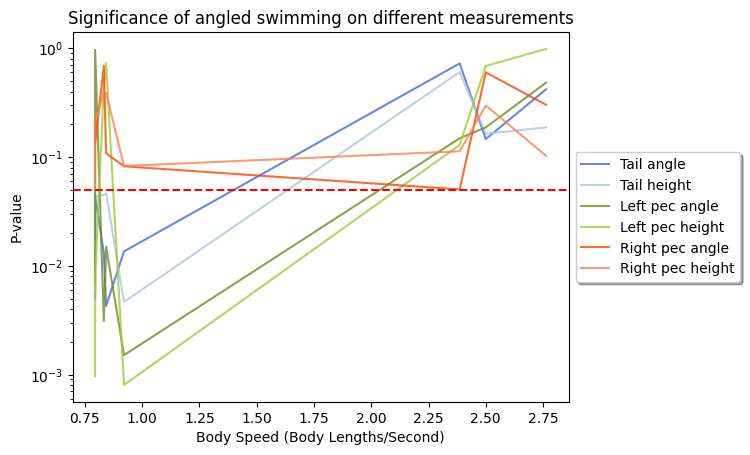

In [ ]:
cx = plt.subplot(1,1,1)
plt.xlabel('Body Speed (Body Lengths/Second)')
plt.ylabel('P-value')
plt.title('Significance of angled swimming on different measurements')

bspeed = (0.795, 0.795, 0.833, 0.843, 0.921, 2.386, 2.5, 2.763)
tang = (0.005018, 0.044104,0.013092,0.004269,0.013566,0.726986,0.146389,0.41992)
theight = (0.005584,0.043118,0.045029,0.04641,0.004654,0.60521,0.164002,0.187332)
lang = (0.006934,0.969368,0.003101,0.014966,0.001507,0.148967,0.187575,0.483128)
lheight = (0.000965,0.008222,0.440975,0.731983,0.000802,0.12904,0.688032,0.987628)
rang = (0.206719,0.132873,0.690883,0.108139,0.08221,0.050396,0.601521,0.302541)
rheight = (0.052707,0.197487,0.401468,0.389775,0.082741,0.113083,0.298354,0.102738)

plt.plot(bspeed, tang, 'royalblue', alpha=0.8, label='Tail angle')
plt.plot(bspeed, theight, 'lightsteelblue', alpha=0.8, label='Tail height')
plt.plot(bspeed, lang, 'olivedrab', alpha=0.8, label='Left pec angle')
plt.plot(bspeed, lheight, 'yellowgreen', alpha=0.8, label='Left pec height')
plt.plot(bspeed, rang, 'orangered', alpha=0.8, label='Right pec angle')
plt.plot(bspeed, rheight, 'coral', alpha=0.8, label='Right pec height')

cx.set_yscale('log')

# Shrink current axis by 20%
box = cx.get_position()
cx.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
cx.legend(loc='center left',ncol=1, bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.axhline(y=0.05, color='red', linestyle= '--')

plt.subplots_adjust(hspace=0)
plt.show()

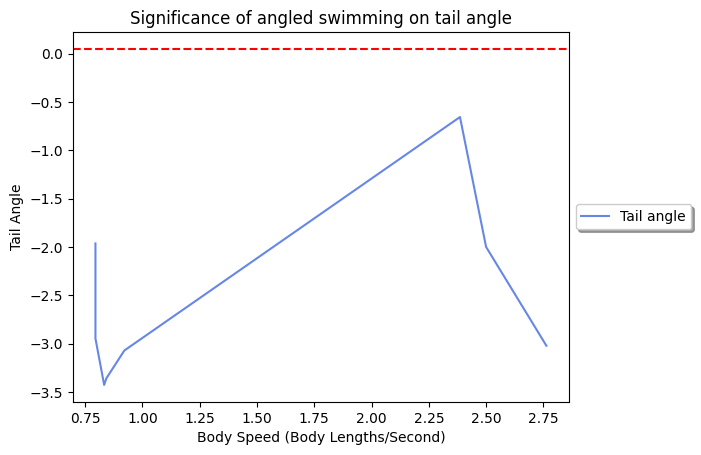

In [ ]:
cx = plt.subplot(1,1,1)
plt.xlabel('Body Speed (Body Lengths/Second)')
plt.ylabel('Tail Angle')
plt.title('Significance of angled swimming on tail angle')

bspeed = (0.795, 0.795, 0.833, 0.843, 0.921, 2.386, 2.5, 2.763)
t215= [-0.13466850362559346, 0.004911739444063138, -0.2377106343757279, -0.023543087551759496, -0.18175040569259926, -0.050386579327997054, -0.19879977298214288, -0.09277490074414034,
-0.039701699745889225, 0.0630014257976883, -0.14674761182328067, -0.015882136888374167, -0.26143164652053397, -0.15627326791492094, -0.3531301131591519, -0.13821912280013726]
t515= [-0.006023252782364648, 0.15287172238437569, -0.181124624874123, 0.021711944600011832, -0.21024875997267958, -0.05580947468294916, -0.4099247921167729, -0.12919399872180148,
-0.017551302411244984, -0.705269980114508, -0.11262702684793457, -0.16685102431463045, -0.006094845753397241, -0.17469531009195657, -0.08319427525134071, -0.21816247500016056,
-0.11861139751508268, 0.00902001820841792, -0.22003128484976092, 0.18522917539862488, -0.22925867204870695, 0.03976534905234413, -0.19590446704215622, -0.11436089331879316]
t315= [-0.23404175189029738, -0.030074647854050472, -0.2821929659285026, -0.09302931828888389, -0.29329030703946396, 0.05411122852600668, -0.2996038848718252, -0.0803218552638846,
-0.23991444932226116, -0.03400253468941463, -0.21377542549093417, 0.008810443099801574, -0.22791077887485187, 0.00687530124779258, -0.3030578836736219, -0.04031566469164197,
-0.33363510087651177, -0.09930735491040982, -0.2787592818990121, -0.0622176717147715, -0.2624185538943827, -0.0071391126601798435, -0.16700464634231113, 0.08509367593262841]
t615= [-0.1969396371396533, -0.05586428122556466, -0.28977841557296824, -0.029992133401754956, -0.15718068100441496, -0.3475179027510913, -0.0529722678753775, -0.01291590186875146,
-0.2304965457786017, -0.15954481332936932, -0.22648339850722377, -0.06038736561858187, -0.15519704684826505, -0.18712358058532455, -0.15620250309693812, -0.21666890813590733,
0.02777619787503894, -0.20847473527917693, -0.08588098647306246, -0.21168030243727715, -0.06668858638237697, -0.17207708574821418, 0.007595324790045973, -0.11282779540556491]
t715= [-0.12958462884981953, -0.22051399053939702, -0.1278362685597834, -0.2190397649633085, -0.15414854154555785, -0.228009163075975, -0.13391749422168073, -0.20333629365978145,
-0.23889951197254705, -0.1330229188234046, -0.26159866662189035, -0.11178511362177505, -0.3148474620807993, -0.14567305616322568, -0.293280018775518, -0.15585696733664928]
t220= [-0.06489468199831129, 0.11436528672395031, -0.12637997787825472, 0.09023929795784644, -0.24404762628158697, 0.040716470988971444, -0.3703241621656002, -0.08372513695500595,
-0.122011389330809, 0.012453104426042801, -0.13650417506839155, 0.11274561986464975, -0.1814429317217207, -0.0039627817504050864, -0.03965233833028487, 0.3671141866015535,
0.23888360488903476, -0.018042165893978435, 0.027257082992901773, -0.050541056935670514, 0.04583336194746666, -0.11907859038168013, 0.09059773180161146, -0.23426927392344846]
t420= [-0.1445169150372112, -0.09884412678040304, -0.3372299504815086, 0.10176318697605076, -0.3195103766609602, -0.05210518077145845, -0.09278716884842857, -0.41391641906449417,
-0.1726403540732624, 0.10253426074586947, -0.12590368668902838, -0.023916760015720174, -0.30447200666889035, 0.0024324635989909733, 0.0011358253516115804, -0.12122309616488453]
t720= [-0.13438583923862996, -0.2975322556600866, -0.038262233573219936, -0.22952337896394104, -0.08270366540185997, -0.26049535401695084, -0.14557121484745253, -0.18807867756597518,
-0.17039419806656217, 0.03515269363126009, -0.2340701319713887, -0.0780275953584419, -0.22656733077624125, -0.10724660175814892, -0.2581833071316197, 0.05662457055045729,
-0.13563699950656163, 0.0923058307941552, -0.24434861853747514, 0.05307236262896191, -0.2617139317491551, 0.015403833725082701, -0.19824628497085045, 0.017301087051045133]
tang= [sum(t215), sum(t515), sum(t315), sum(t615), sum(t715), sum(t220), sum(t420), sum(t720)]
plt.plot(bspeed, tang, 'royalblue', alpha=0.8, label='Tail angle')

# Shrink current axis by 20%
box = cx.get_position()
cx.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
cx.legend(loc='center left',ncol=1, bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.axhline(y=0.05, color='red', linestyle= '--')

plt.subplots_adjust(hspace=0)
plt.show()

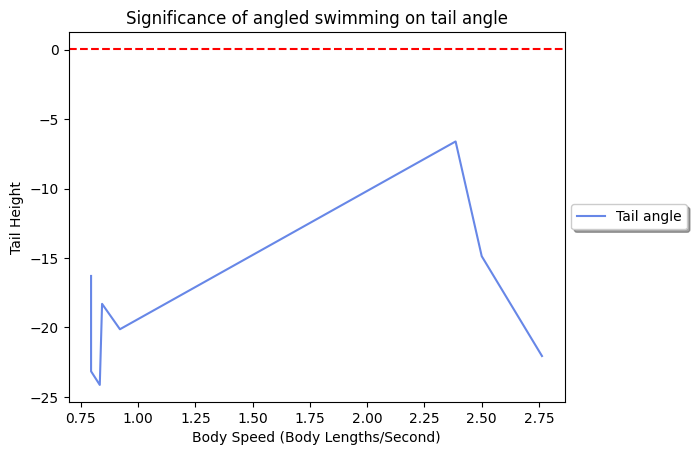

In [ ]:
cx = plt.subplot(1,1,1)
plt.xlabel('Body Speed (Body Lengths/Second)')
plt.ylabel('Tail Height')
plt.title('Significance of angled swimming on tail angle')

bspeed = (0.795, 0.795, 0.833, 0.843, 0.921, 2.386, 2.5, 2.763)
t215= [-1.130405619793133, 0.042225737411514, -1.9241109848226174, -0.2056679697276457, -1.8063881041809846, -0.4327926532748764, -1.7194144230409742, -0.3248508502733721,
-0.4350715319595055, 0.49264320398293915, -1.2788444985097656, -0.13103472926478785, -2.0664031380733703, -1.2492928327701094, -2.8330318729932413, -1.2899242591042537]
t515= [-0.05074122770418921, 1.2429617924334697, -1.559390213460957, 0.268309933525527, -1.8173948928197596, -0.46581794971720036, -3.015484980879753, -1.0417717832503546,
0.05219588682869043, -4.593774759502655, -1.065284004494774, -1.3906128892025225, -0.051240265686588626, -1.4648888021793456, -0.6706205315183412, -1.7595936272845933,
-1.4159999999999884, 0.1411282484030511, -1.804874229196297, 1.5036868466399989, -1.8736246789729332, 0.32645817054331316, -1.663766382768153, -0.9860340716983657]
t315= [-1.4166513254838389, -0.2367197980786007, -2.1258276363576876, -0.6312331332574725, -2.011789385080098, 0.3749760677020091, -2.0584208408410247, -0.6089214904947722,
-1.2825235009885738, 0.6203253679943969, -1.8314240506361983, -0.286663872413152, -1.5970756461368267, -0.02450110147317593, -2.2685003266770782, -0.3115786151313722,
-2.482569346257758, -0.8101070256468703, -2.1011252054386853, -0.4797028310673491, -1.9099999999999977, -0.05713583635024834, -1.2578969390291268, 0.6582415967577967]
t615= [-2.5530473904432935, -0.4423679678780289, -2.2671365959131613, -0.23114010853335923, -1.1926051217415308, 0.3999999999999986, -0.2320300562982081, -0.07337753303507,
0.9973784163812437, -1.7355155688261668, -1.2455963713357114, -1.6521477086466172, -0.514619382389129, -1.2187905357142839, 1.2140341000138017, -1.22996143288187,
0.21664250781891947, -1.5784811624319055, -0.671435561034389, -1.5654326334496744, -0.5289185485240804, -1.330848026804415, 0.05900058838742474, -0.9244208206973159]
t715= [-0.8774334543379391, -1.5128626640345613, -0.8904494345085494, -1.4519854262092045, -1.0800076273405426, -1.6266564762826958, -0.926905322974208, -1.2448716177362338,
-1.6595418848621788, -0.8341755579783072, -1.7371488205636054, -0.8539795681078759, -2.1355926481803515, -0.47127133933799414, -1.9410615656282952, -0.8848813227688774]
t220= [-0.6363632229327395, 1.0999999999999943, -1.016708121141386, 0.7267561500556173, -1.9058553787954762, 0.3161422875003389, -2.6921734378527415, -0.5516913803702708,
-0.7940338761634903, 0.04844346733559308, -1.0549815086756555, 0.3901902752125651, -1.1229925863982695, -0.19122361755310086, -1.231979688843973, 2.7868755817951913,
1.7622584478408831, -0.3170877899889297, 0.2210134574353287, -0.41190563173948, 0.06295114936721335, -0.9633851717972515, 0.7430345544788045, -1.8784364557142184]
t420= [-1.193243367939347, -0.8124275115593202, -2.615594610833628, 0.8039607493066241, -2.526028499284598, -1.174939034566948, -0.12387802408690023, -2.507326556926606,
-1.3235322767303803, 0.8884843647091794, -0.19946423186803927, -0.9601436229513706, 0.008920944164932117, -2.076543074974121, 0.019061201170647246, -1.077945275901036]
t720= [-2.0041033516020215, -0.26732071223757875, -1.5730657470964167, -0.6818223971665262, -1.8573963867961873, -0.995286665996943, -1.3694218318467803, -0.9381827154823795,
-1.2610018683415687, 0.2637073302326844, -1.433836848497093, -0.48300447467342644, -1.4570160185711136, -0.8640302111988198, -1.8724687968913465, 0.40974636382145885,
0.6203282314307239, -1.7040148575746905, 0.38350702688006727, -2.0084097477743676, -1.7479273584353263, 0.10549600923995779, -1.2920898322946477, -0.029369614526516142]
tang= [sum(t215), sum(t515), sum(t315), sum(t615), sum(t715), sum(t220), sum(t420), sum(t720)]
plt.plot(bspeed, tang, 'royalblue', alpha=0.8, label='Tail angle')

# Shrink current axis by 20%
box = cx.get_position()
cx.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
cx.legend(loc='center left',ncol=1, bbox_to_anchor=(1, 0.5), fancybox=True, shadow=True)
plt.axhline(y=0.05, color='red', linestyle= '--')

plt.subplots_adjust(hspace=0)
plt.show()

In [ ]:
from scipy import interpolate

uploaded = files.upload()
df_name = next(iter(uploaded.keys()))
table = pd.read_table(df_name, delimiter=",", header=0)
t, snoutx, snouty, gillx, gilly = table["Time"], table["Snout X"], table["Snout Y"], table["COM X"], table["COM Y"]
afx, afy, vtx, vty = table["Anal Fin X"], table["Anal Fin Y"], table["Tail X"], table["Tail Y"]
coeffx = np.polyfit(t, vtx, 10)
coeffy = np.polyfit(t, vty, 10)

Saving Fish6T62 15.csv to Fish6T62 15.csv


<ipython-input-55-d70f83eaabba>:8: RankWarning: Polyfit may be poorly conditioned
  coeffx = np.polyfit(t, vtx, 10)
<ipython-input-55-d70f83eaabba>:9: RankWarning: Polyfit may be poorly conditioned
  coeffy = np.polyfit(t, vty, 10)


In [ ]:
range = np.arange(np.round(min(t)), np.round(max(t)),1)
print(range)
plt.plot(range, coeffx[range], label = "trend X")
plt.plot(range, coeffy[range], label = "trend Y")
plt.scatter(t,vtx, s=0.1,color="royalblue", label = "X values")
plt.scatter(t,vty, s=0.1,color="bisque",label = "Y values")
plt.legend()

[ 93.  94.  95.  96.  97.  98.  99. 100.]


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
print(type(coeffx))

<class 'numpy.ndarray'>
